In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import torch

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['font.size'] = 6
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.25
plt.rcParams['image.origin'] = 'upper'
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.format'] = 'svg'
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.transparent'] = True
plt.rcParams['savefig.pad_inches'] = 0.
plt.rcParams['savefig.dpi'] = 200

from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Can we use PDEFIND to uncover a differential equation for $u$ directly?

In the original investigation, they performed a hydrodynamic gradient expansion to leading order in $\partial_x \rho$ and found a Burger's equation. We repeat this analysis attempting to learn an equation from the data directly using the SINDy method.

In [6]:
import pysindy as ps
from sklearn.metrics import r2_score


u = np.load('data/rescaled_1d.npy', mmap_mode='r')
y0 = u[:50, -100:].copy()
print(u.shape)

def MAE(input, target):
    return np.mean(np.abs(input - target))
def rMAE(input, target):
    return np.mean(np.abs(input - target)) / np.mean(np.abs(target))

y = u[:50, -100:].copy().T
tmin, xmin = 0, 0
frame_rate = 60 / 4
pixel_size = 18 / u.shape[1] #mm
xmax = y.shape[0] * pixel_size
tmax = y.shape[1] / frame_rate
x = np.linspace(xmin, xmax, y.shape[0])
t = np.linspace(tmin, tmax, y.shape[1])
dx = x[1] - x[0]
dt = t[1] - t[0]
y = y.reshape([x.shape[0], t.shape[0], 1])


# Define PDE library that includes nonlinear terms and
# third-order in spatial derivatives.
library_functions = [lambda x: x]
library_function_names = [lambda x: x]
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=5, 
                        spatial_grid=x,
                        include_interaction=True,
                        include_bias=True, 
                        is_uniform=True)

optimizer = ps.STLSQ(threshold=10, alpha=1e-2, normalize_columns=True)
sindy = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['rho'])
sindy.fit(y, t=dt)
sindy.print()

'''
Upon testing, it appears that the learned order-3 equation completely breaks when integrated
So restrict ourselves to order 2
'''

pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=2, 
                        spatial_grid=x,
                        include_interaction=True,
                        include_bias=False, 
                        is_uniform=True)

optimizer = ps.STLSQ(threshold=5, alpha=1e-2, normalize_columns=True)
sindy = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['rho'])
sindy.fit(y, t=dt)
sindy.print()

(112, 200)
(rho)' = 3.860 rho_1 + -0.292 rho_111 + -2.713 rhorho_1 + 0.533 rhorho_111
(rho)' = 4.426 rho_1 + -3.836 rhorho_1


PDEFIND has found that the predicted variable $\rho$
\begin{equation}
    \partial_t \rho + 3.8 \ \rho \partial_x \rho - 4.4 \ \partial_x \rho = 0
\end{equation}

Finished integration:  (50, 100) (50,)
R2 Score for rho: -0.232
MAE Score for rho Experiments: 0.14


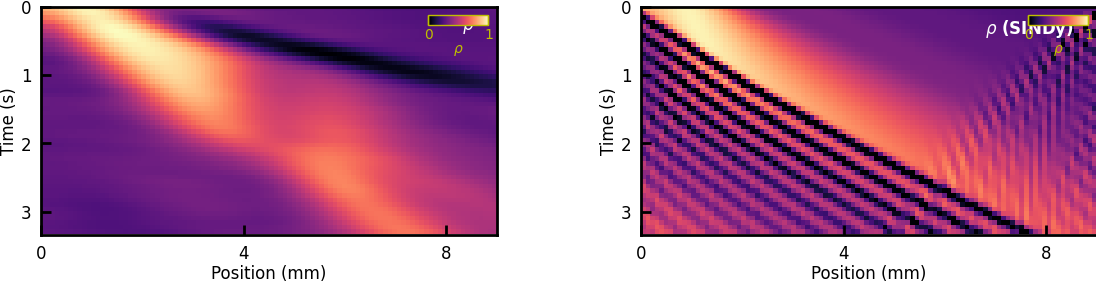

In [4]:
from scipy.ndimage import gaussian_filter

def rk4(u, func, dt):
    k1 = dt * func(u)
    k2 = dt * func(u + 0.5 * k1)
    k3 = dt * func(u + 0.5 * k2)
    k4 = dt * func(u + k3)
    return u + (k1 + 2 * k2 + 2 * k3 + k4) / 6

sigma = 1
mode='wrap'
def func(u):
    u_x = gaussian_filter(u, sigma, order=1, mode=mode) / dx
    u_xx = gaussian_filter(u, sigma, order=2, mode=mode) / dx**2
    u_xxx = gaussian_filter(u, sigma, order=3, mode=mode) / dx**3
    # The higher-order PDE breaks, and the simulation blows up
    #return 3.86 * u_x - 2.71 * u * u_x - 0.29 * u_xxx + 0.53 * u * u_xxx
    return 4.43 * u_x - 3.84 * u * u_x

i, ti = 0, tmin
u_m = []
ui = y0[0].copy()
while i < y0.shape[0]:
    u_m.append(ui.copy())
    ui = rk4(ui, func, dt)
    if np.any(np.isnan(u)):
        print('Breaking early')
        break
    i += 1
    ti += dt
    
u_m = np.stack(u_m)
#u_m = gaussian_filter(u_m, sigma=1) #Smooth to remove edge artifacts
t_m = np.linspace(0, ti, len(u_m))
print('Finished integration: ', u_m.shape, t_m.shape)

#print(f'R2 Score for u: {r2_score(y0.flatten(), u_m.flatten()):.3g}')

print(f'R2 Score for rho: {r2_score(y0.flatten(), u_m.flatten()):.3g}')
print(f'MAE Score for rho Experiments: {np.mean(np.abs(y0 - u_m)):.3g}')


kwargs = dict(extent=[xmin, xmax, tmax, tmin], vmin=0, vmax=1)

def plot_density_field(ax, rho, kwargs):
    #Note - video flows right to left, but we present things left to right
    im = ax.imshow(rho[:, ::-1], **kwargs)
    ax.set_aspect('auto')
    ax.set(xlabel='$x$ (mm)', xticks=[0, 4, 8],
           ylabel='$t$ (s)', yticks=[0, 1, 2, 3])
    cbax = inset_axes(ax, width=0.3, height=0.05, loc='upper right')
    cbar = plt.colorbar(im, cax=cbax, ticks=[0,1], orientation='horizontal')
    color='y'
    fontsize=plt.rcParams['font.size'] - 1
    cbar.ax.set_xlabel('$\\rho$', fontsize=fontsize, color=color, labelpad=0.5)
    cbar.ax.set_xticklabels([0, 1], fontsize=fontsize, color=color)
    cbar.outline.set_edgecolor(color)
    cbar.outline.set_linewidth(0.5)
    cbar.ax.xaxis.set_tick_params(color='y', width=0.5, pad=1)
    plt.setp(plt.getp(cbax, 'xticklabels'), color=color)

#Note - video flows right to left, but we present things left to right
fig, ax = plt.subplots(1, 2, figsize=(6, 1.5), dpi=200, 
                       squeeze=False, constrained_layout=True)

plot_density_field(ax[0,0], y0, kwargs)
plot_density_field(ax[0,1], u_m, kwargs)
kwargs = dict(cmap='jet', extent=[xmin, xmax, tmax, tmin], origin='upper',
              vmin=0, vmax=1)
ax[0, 0].text(0.95, 0.95, '$\\rho$', 
              color='white', fontweight='bold',
              transform=ax[0, 0].transAxes,
              va='top', ha='right')

ax[0, 1].text(0.95, 0.95, '$\\rho$ (SINDy)', 
              color='white', fontweight='bold',
              transform=ax[0, 1].transAxes,
              va='top', ha='right')

for a in ax.flatten():
    a.set_aspect(xmax / tmax / 2.)
    a.set(xlabel='Position (mm)',
          ylabel='Time (s)')

#plt.savefig('Figures/Direct_SINDy.svg', bbox_inches='tight')

When allowing higher order terms, PDEFIND has found that the variable $\rho$ is governed by the equation
\begin{equation}
    \partial_t \rho = (3.9 - 2.7 \rho) \partial_x \rho - (0.29 - 0.53 \rho) \partial_x^3 \rho
\end{equation}
Unfortunately, this equation is numerically unstable and eventually blows up. This is likely due to the difficulty in identifying higher-order derivative terms which amplify noise in experimental data. 

Breaking early
Finished integration:  (3, 100) (3,)
Could not get accuracy metrics due to NaNs


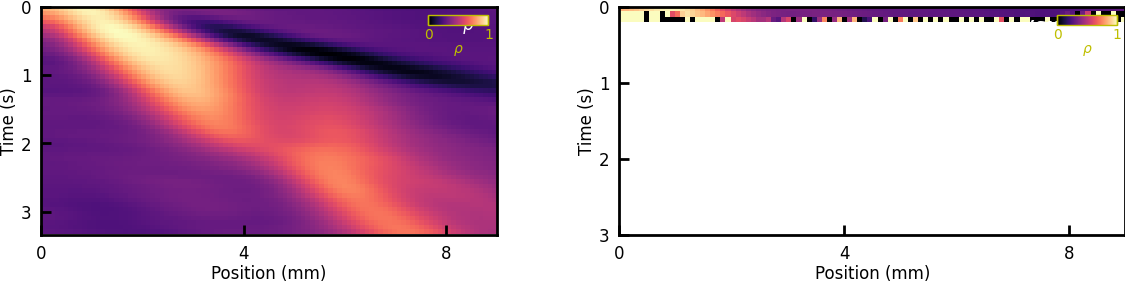

In [11]:
from scipy.ndimage import gaussian_filter

def rk4(u, func, dt):
    k1 = dt * func(u)
    k2 = dt * func(u + 0.5 * k1)
    k3 = dt * func(u + 0.5 * k2)
    k4 = dt * func(u + k3)
    return u + (k1 + 2 * k2 + 2 * k3 + k4) / 6

sigma = 1
mode='wrap'
def func(u):
    u_x = gaussian_filter(u, sigma, order=1, mode=mode) / dx
    u_xx = gaussian_filter(u, sigma, order=2, mode=mode) / dx**2
    u_xxx = gaussian_filter(u, sigma, order=3, mode=mode) / dx**3
    # The higher-order PDE breaks, and the simulation blows up
    return 3.86 * u_x - 2.71 * u * u_x - 0.29 * u_xxx + 0.53 * u * u_xxx
    #return 4.43 * u_x - 3.84 * u * u_x

i, ti = 0, tmin
u_m = []
ui = y0[0].copy()
while i < y0.shape[0]:
    u_m.append(ui.copy())
    ui = rk4(ui, func, dt)
    if np.any(np.isnan(ui)):
        print('Breaking early')
        break
    i += 1
    ti += dt
    
u_m = np.stack(u_m)
#u_m = gaussian_filter(u_m, sigma=1) #Smooth to remove edge artifacts
t_m = np.linspace(0, ti, len(u_m))
print('Finished integration: ', u_m.shape, t_m.shape)

try:
    print(f'R2 Score for rho: {r2_score(y0.flatten(), u_m.flatten()):.3g}')
    print(f'MAE Score for rho Experiments: {np.mean(np.abs(y0 - u_m)):.3g}')
except:
    print('Could not get accuracy metrics due to NaNs')

def plot_density_field(ax, rho, kwargs):
    #Note - video flows right to left, but we present things left to right
    im = ax.imshow(rho[:, ::-1], **kwargs)
    ax.set_aspect('auto')
    ax.set(xlabel='$x$ (mm)', xticks=[0, 4, 8],
           ylabel='$t$ (s)', yticks=[0, 1, 2, 3])
    cbax = inset_axes(ax, width=0.3, height=0.05, loc='upper right')
    cbar = plt.colorbar(im, cax=cbax, ticks=[0,1], orientation='horizontal')
    color='y'
    fontsize=plt.rcParams['font.size'] - 1
    cbar.ax.set_xlabel('$\\rho$', fontsize=fontsize, color=color, labelpad=0.5)
    cbar.ax.set_xticklabels([0, 1], fontsize=fontsize, color=color)
    cbar.outline.set_edgecolor(color)
    cbar.outline.set_linewidth(0.5)
    cbar.ax.xaxis.set_tick_params(color='y', width=0.5, pad=1)
    plt.setp(plt.getp(cbax, 'xticklabels'), color=color)

#Note - video flows right to left, but we present things left to right
fig, ax = plt.subplots(1, 2, figsize=(6, 1.5), dpi=200, 
                       squeeze=False, constrained_layout=True)

kwargs = dict(extent=[xmin, xmax, tmax, tmin], vmin=0, vmax=1)
plot_density_field(ax[0,0], y0, kwargs)
kwargs = dict(extent=[xmin, xmax, u_m.shape[0] / frame_rate, tmin], vmin=0, vmax=1)
plot_density_field(ax[0,1], u_m, kwargs)
kwargs = dict(cmap='jet', extent=[xmin, xmax, tmax, tmin], origin='upper',
              vmin=0, vmax=1)
ax[0, 0].text(0.95, 0.95, '$\\rho$', 
              color='white', fontweight='bold',
              transform=ax[0, 0].transAxes,
              va='top', ha='right')

ax[0, 1].text(0.95, 0.95, '$\\rho$ (SINDy)', 
              color='white', fontweight='bold',
              transform=ax[0, 1].transAxes,
              va='top', ha='right')

for a in ax.flatten():
    a.set_aspect(xmax / tmax / 2.)
    a.set(xlabel='Position (mm)',
          ylabel='Time (s)')